# Обработка новостей первой недели

In [172]:
import sklearn.cluster as sc
import random
import pandas as pd
import numpy as np
import time
import datetime

%matplotlib inline
import matplotlib.pyplot as plt

num_of_clusters = 2

In [173]:
months = {
    'января':'01',
    'февраля':'02',
    'марта':'03',
    'апреля':'04',
    'мая':'05',
    'июня':'06',
    'июля':'07',
    'августа':'08',
    'сентября':'09',
    'октября':'10',
    'ноября':'11',
    'декабря':'12'
}

In [174]:
def correct_text_news(text):
    try:
        if text.find('РИА Новости')!=-1:
            text_start = text.find('РИА Новости')+len('РИА Новости')+2
            text = text[text_start:]
    except:
        print(text)
    return text

In [175]:
def convert_to_datetime(date,time):
    d = date.split()
    d = d[0] + '-' + months[d[1]] +  '-' + d[2]
    
    return pd.to_datetime(d + ' '+ time + ':00')

# convert_to_datetime(data.date[0], data.time[0])

In [176]:
def take_list_from_tags(tags_str):
    s = tags_str[1:-1]
    s = s.replace(' ','_')
    s = s.replace("',_'",' ')
    s = s.replace("'",'')
    s = s.split()
    return s

**Начало работы**

In [273]:
file_name = 'last_week.csv'
data = pd.read_csv(file_name).drop('Unnamed: 0',axis=1)
data.dropna(subset=['text'], inplace=True)
data.index = np.array([i for i in range(len(data.index-1))])
data['text'] = [correct_text_news(data.loc[i,'text']) for i in range(len(data))]
data.head()

,date,time,views,headline,link,tags,text
0,31 декабря 2020,23:55,11423,Алиев ответил на обвинения ЮНЕСКО из-за армянс...,https://ria.ru/20201231/pamyatniki-1591740604....,"['Ситуация в Нагорном Карабахе', 'Никол Пашиня...",Президент Азербайджана Ильхам Алиев заявил в н...
1,31 декабря 2020,23:19,40055,ВОЗ внесла вакцину Pfizer в список для экстрен...,https://ria.ru/20201231/vaktsina-1591739960.html,"['Распространение нового коронавируса', 'Панам...",Всемирная организация здравоохранения (ВОЗ) вн...
2,31 декабря 2020,21:42,41404,В Сургуте Дед Мороз разбился в ДТП,https://ria.ru/20201231/dtp-1591738065.html,"['Россия', 'Снегурочка', 'Дед Мороз', 'Сургут'...",Мужчина в костюме Деда Мороза попал в крупное ...
3,31 декабря 2020,21:16,29509,В Москве задержали или отменили около 105 рейсов,https://ria.ru/20201231/reys-1591737184.html,"['Домодедово (аэропорт)', 'Шереметьево (аэропо...",В московских аэропортах вечером 31 декабря зад...
4,31 декабря 2020,20:07,273915,Депутат Рады надел шапку с красной звездой и о...,https://ria.ru/20201231/shapka-1591735431.html,"['Оппозиционная платформа - За жизнь', 'Ситуац...","Депутат Рады от партии ""Оппозиционная платформ..."


tags = [] 
for _ in  data.tags:
    tags+=take_list_from_tags(_)
ut = np.unique(tags) #1168

tagsu = dict(zip(ut, np.zeros(len(ut)).astype('int64')))
for i in tags:
    tagsu[i]+=1
    
utu = np.array([tagsu[i] for i in ut])

ut[np.where(utu >10)]

**1168**

In [274]:
data['dt'] = [convert_to_datetime(data.date[i], data.time[i]) for i in range(len(data))]
data['main_text'] = data.headline + '. '+ data.text
data = data.drop(['date','time', 'link', 'headline', 'text'],axis=1)
data.head()

,views,tags,dt,main_text
0,11423,"['Ситуация в Нагорном Карабахе', 'Никол Пашиня...",2020-12-31 23:55:00,Алиев ответил на обвинения ЮНЕСКО из-за армянс...
1,40055,"['Распространение нового коронавируса', 'Панам...",2020-12-31 23:19:00,ВОЗ внесла вакцину Pfizer в список для экстрен...
2,41404,"['Россия', 'Снегурочка', 'Дед Мороз', 'Сургут'...",2020-12-31 21:42:00,В Сургуте Дед Мороз разбился в ДТП. Мужчина в ...
3,29509,"['Домодедово (аэропорт)', 'Шереметьево (аэропо...",2020-12-31 21:16:00,В Москве задержали или отменили около 105 рейс...
4,273915,"['Оппозиционная платформа - За жизнь', 'Ситуац...",2020-12-31 20:07:00,Депутат Рады надел шапку с красной звездой и о...


In [336]:
t = data.groupby(pd.Grouper(key="dt", freq="1D"))['tags'].apply(list)

In [361]:
tt = [[] for _ in range(len(t))]
for i in range(len(tt)):
    for j in range(len(t[i])):
        tt[i]+=take_list_from_tags(t[i][j])
        
tt
    

[['AMC_Fight_Nights_Global',
  'Единоборства',
  'Вячеслав_Василевский',
  'Магомед_Исмаилов',
  'Смешанные_боевые_искусства_(ММА)',
  'Владимир_Минеев',
  'Давид_Залкалиани',
  'Георгий_Гахария',
  'Саломе_Зурабишвили',
  'Тбилиси',
  'Грузия',
  'В_мире',
  'Россия',
  'Днепр_(город)',
  'Дмитрий_Кулеба',
  'Юрий_Гемпель',
  'Сергей_Аксенов_(политик)',
  'МИД_Украины',
  'Республика_Крым',
  'Севастополь',
  'Украина',
  'В_мире',
  'Гельмут_Оберлендер',
  'Симон_Визенталь',
  'Оттава',
  'СССР',
  'Торонто',
  'Украина',
  'В_мире',
  'Шоубиз',
  'В_мире',
  'Джанлука_Вакки',
  'Италия',
  'Россия',
  'Счетная_палата_РФ',
  'Общество',
  'Распространение_нового_коронавируса',
  'Александр_Бутенко',
  'Коронавирус_в_России',
  'Коронавирус_COVID-19',
  'Россия',
  'Здоровье',
  'Общество',
  'Максим_Лалакин',
  'Россия',
  'Центральный_Банк_РФ_(ЦБ_РФ)',
  'Деньги',
  'Экономика',
  'Распространение_нового_коронавируса',
  'Коронавирус_COVID-19',
  'Великобритания',
  'Москва',
  'ЮАР

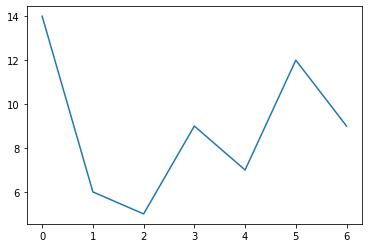

In [363]:
c = np.zeros(len(tt))
for i in range(len(tt)):
    for j in range(len(tt[i])):
        if tt[i][j] in utpl[-1]:
            c[i]+=1
            
plt.plot(c)
plt.show()

In [356]:
c

array([ 6.,  9., 15., 11., 10.,  8.,  7.])

In [290]:
tags = [] 
for _ in  data.tags:
    tags+=take_list_from_tags(_)
ut = np.unique(tags) #1168

tagsu = dict(zip(ut, np.zeros(len(ut)).astype('int64')))
for i in tags:
    tagsu[i]+=1
    
utu = np.array([tagsu[i] for i in ut])

ut[np.where(utu >10)]

array(['Авторы', 'Азербайджан', 'Александр_Лукашенко', 'Армения',
       'Баренцево_море', 'Безопасность', 'Белоруссия', 'В_мире',
       'Вакцина_"Спутник_V"', 'Великобритания', 'Владимир_Зеленский',
       'Владимир_Путин', 'Вокруг_спорта', 'Германия', 'Госдума_РФ',
       'Дмитрий_Кулеба', 'Дмитрий_Песков', 'Дональд_Трамп', 'Здоровье',
       'Здоровье_-_Общество', 'Киев', 'Китай', 'Коронавирус_COVID-19',
       'Коронавирус_в_России', 'Коронавирусы', 'Космос_-_РИА_Наука',
       'Крушение_рыболовного_судна_"Онега"_в_Баренцевом_море', 'Культура',
       'МИД_Украины', 'Молодежная_сборная_России_по_хоккею_с_шайбой',
       'Молодежный_чемпионат_мира_по_хоккею', 'Москва', 'Наука',
       'Никол_Пашинян', 'Новый_год', 'Новый_год—2021', 'ООН', 'Общество',
       'Политика', 'Происшествия', 'Распространение_нового_коронавируса',
       'Религия_и_мировоззрение', 'Республика_Крым', 'Россия', 'СССР',
       'США', 'Санкт-Петербург', 'Севастополь', 'Сирия',
       'Ситуация_в_Нагорном_Караб

In [316]:
utpl = ut[np.where(utu >50)]
utpl

array(['В_мире', 'Владимир_Путин', 'Коронавирус_COVID-19',
       'Коронавирус_в_России', 'Москва', 'Общество', 'Происшествия',
       'Распространение_нового_коронавируса', 'Россия', 'США', 'Украина'],
      dtype='<U178')

In [357]:
tags = np.array(tags)
tags = tags.reshape(10,-1)

In [365]:
c = np.zeros(len(tags))
for i in range(len(tags)):
    for j in range(len(tags[i])):
        if tags[i][j] in utpl[-1]:
            c[i]+=1
            
c

array([9., 8., 6., 5., 5., 7., 4., 4., 8., 6.])

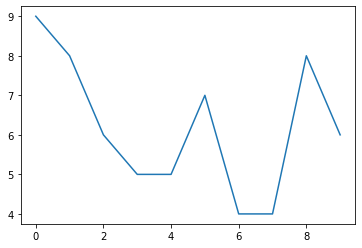

In [366]:
plt.plot(c)
plt.show()